In [1]:
import os 
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter


os.chdir('/Users/louise/Documents/PJTS/ECCE/data')

**Goal:** Assess whether our model is robust to climate change.

To evaluate the impact of global warming, we compare the parameters of our model with those of a model trained on future data (which represents the best possible scenario we can achieve).

**Idea:** In the best-case scenario, the effect of climate change is fully captured by the covariate values, meaning the model parameters remain unchanged — including the spline shapes, etc.

To investigate this, we study the quantiles of the GEV distributions produced by both models and analyze how they differ.

# 0. Data Collection

In [2]:
# ------------------
#   VGAM Results 
# ------------------

# Results — GEV Predictions Using Present-Day Model with Future Covariates 
df_pf = pd.read_csv('Results/results_pf12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_pf.rename(columns = {'scale_pred' : 'scaleF1', 'shape_pred' : 'shapeF1', 'loc_pred' : 'locF1'}, inplace = True)

# Results — GEV Predictions Using Future-Trained Model with Future Covariates
df_ff = pd.read_csv('Results/results_ff12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_ff.rename(columns = {'scale_pred' : 'scaleF2', 'shape_pred' : 'shapeF2', 'loc_pred' : 'locF2'}, inplace = True)

# Results — GEV Predictions Using Present-Day Model with Present Covariates
df_pp = pd.read_csv('Results/results_pp12.csv')[['rlat', 'rlon', 'scale_pred', 'shape_pred', 'loc_pred']]
df_pp.rename(columns = {'scale_pred' : 'scalePP', 'shape_pred' : 'shapePP', 'loc_pred' : 'locPP'}, inplace = True)

# Merge
df = pd.merge(df_pf, df_ff, on = ['rlat', 'rlon'])
df.drop_duplicates(inplace = True)
df = pd.merge(df, df_pp, on = ['rlat', 'rlon'])
df.drop_duplicates(inplace = True)

# Add "True" Parameters 
params = pd.read_csv('2_True_Parameters/gev2_param_true_future.csv')[['rlon', 'rlat', 'loc', 'scale', 'shape']]
params.rename(columns = {'loc' : 'locF', 'scale' : 'scaleF', 'shape' : 'shapeF'}, inplace = True)
df = pd.merge(df, params, on = ['rlat', 'rlon'])

params = pd.read_csv('2_True_Parameters/gev2_param_true_present.csv')[['rlon', 'rlat', 'loc', 'scale', 'shape']]
params.rename(columns = {'loc' : 'locP', 'scale' : 'scaleP', 'shape' : 'shapeP'}, inplace = True)
df = pd.merge(df, params, on = ['rlat', 'rlon'])
df.drop_duplicates(inplace = True)

del df_ff, df_pf, df_pp, params

In [3]:
# ------------------
#   VGLM Results 
# ------------------

df_pf_vglm = pd.read_csv('Results/results_pf12_vglm.csv')[['rlat', 'rlon', 'scale_pred_vglm', 'shape_pred_vglm', 'loc_pred_vglm']]
df_pf_vglm.rename(columns = {'scale_pred_vglm' : 'scaleF1', 'shape_pred_vglm' : 'shapeF1', 'loc_pred_vglm' : 'locF1'}, inplace = True)
df_ff_vglm = pd.read_csv('Results/results_ff12_vglm.csv')[['rlat', 'rlon', 'scale_pred_vglm', 'shape_pred_vglm', 'loc_pred_vglm']]
df_ff_vglm.rename(columns = {'scale_pred_vglm' : 'scaleF2', 'shape_pred_vglm' : 'shapeF2', 'loc_pred_vglm' : 'locF2'}, inplace = True)
df_vglm = pd.merge(df_pf_vglm, df_ff_vglm, on = ['rlat', 'rlon'])
df_vglm.drop_duplicates(inplace = True)

df_pp_vglm = pd.read_csv('Results/results_pp12_vglm.csv')[['rlat', 'rlon', 'scale_pred_vglm', 'shape_pred_vglm', 'loc_pred_vglm']]
df_pp_vglm.rename(columns = {'scale_pred_vglm' : 'scalePP', 'shape_pred_vglm' : 'shapePP', 'loc_pred_vglm' : 'locPP'}, inplace = True)
df_vglm = pd.merge(df_vglm, df_pp_vglm, on = ['rlat', 'rlon'])
df_vglm.drop_duplicates(inplace = True)

params = pd.read_csv('2_True_Parameters/gev2_param_true_future.csv')[['rlon', 'rlat', 'loc', 'scale', 'shape']]
params.rename(columns = {'loc' : 'locF', 'scale' : 'scaleF', 'shape' : 'shapeF'}, inplace = True)
df_vglm = pd.merge(df_vglm, params, on = ['rlat', 'rlon'])

params = pd.read_csv('2_True_Parameters/gev2_param_true_present.csv')[['rlon', 'rlat', 'loc', 'scale', 'shape']]
params.rename(columns = {'loc' : 'locP', 'scale' : 'scaleP', 'shape' : 'shapeP'}, inplace = True)
df_vglm = pd.merge(df_vglm, params, on = ['rlat', 'rlon'])
df_vglm.drop_duplicates(inplace = True)

del df_ff_vglm, df_pf_vglm, df_pp_vglm, params

# 1. Computation of Quantiles

We select the following list of quantiles:
[0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95],
which we will compute for each of the following density estimates at high-resolution grid points (2 km):

- P: Density at each grid point based on high-resolution data from the past climate
- F: Density at each grid point based on high-resolution data from the future climate
- F1: Predicted future density from the model trained on past data
- F2: Predicted future density from the model trained on future data
- PP: Predicted past density from the model trained on past data. 

These quantiles will then be used to construct various indicators to help us analyze the impact of climate change on the model.



It aims to:

1. Compute theoretical quantiles from model parameters
2. Calculate empirical robustness gaps between two models
3. Decompose these gaps into interpretable components ($\delta$, $\varepsilon$)
4. Further decompose $\delta$ into contributions from location ($\mu$), scale ($\sigma$), and shape ($\xi$)
5. Evaluate the consistency between empirical and theoretical decompositions


**Empirical Robustness Gap**

The pintball loss used is computed as:

$$
L_q(y, \hat{y}) = (q - \mathbf{1}_{\{y < \hat{y}\}})(y - \hat{y})
$$

The empirical robustness gap is then:

$$
E = L_q(y, \hat{y}_{F1}) - L_q(y, \hat{y}_{F2})
$$

**Theoretical Decomposition**

We define:

- $\Delta = \hat{y}_{F1} - \hat{y}_{F2}$
- $\varepsilon = \hat{y}_{F2} - \hat{y}_F$

Then compute:

- $T_1 = \Delta \cdot (q - \mathbf{1}_{\{y < \hat{y}_{F2}\}})$
- $T_2 = \Delta \cdot (\mathbf{1}_{\{y < \hat{y}_F\}} - \mathbf{1}_{\{y < \hat{y}_{F2}\}})$

Their sum approximates the empirical gap:$E_2 = T_1 + T_2$

Residual: $R_2 = E - E_2$

**Delta Decomposition (Location, Scale, Shape)**

We further decompose: $\Delta = Q_{F1} - Q_{F2}$

Into contributions:

- **Location term**:
  $
  T_\mu = \mu_{F1} - \mu_{F2}
  $
- **Scale term**:
  $
  T_\sigma = \frac{\sigma_{F1} - \sigma_{F2}}{\xi_{F2}} \left[ (-\log q)^{-\xi_{F2}} - 1 \right]
  $
- **Shape term**:
  $
  T_\xi = \frac{\sigma_{F1}}{\xi_{F1}} \left[ (-\log q)^{-\xi_{F1}} - 1 \right] - \frac{\sigma_{F1}}{\xi_{F2}} \left[ (-\log q)^{-\xi_{F2}} - 1 \right]
  $
- **Residual**:
  $
  R = Q_{F1} - Q_{F2} - T_\mu - T_\sigma - T_\xi
  $

Then compute:

$$
E_3 = (q - \mathbf{1}_{\{y < \hat{y}_{F2}\}})(T_\mu + T_\sigma + T_\xi + R)
$$

With residual:
$
R_3 = E - E_3
$

**Repetition for VGLM**

All previous steps are repeated using a second dataset from the **VGLM** model, allowing for side-by-side comparison of robustness and interpretability across models.


In [4]:
liste_RE = []
liste_RE2 = []
liste_RE2_T1, liste_RE2_T2 = [], []
liste_RE_vglm = []

liste_quantile = np.array([0.01, 0.05, 0.10, 0.20, 0.30, 0.40, 0.50, 0.60, 0.70, 0.80, 0.90, 0.95, 0.99])

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1 : strq += '0'
    
    # -----------------
    # ----VGAM---------
    # -----------------

    df = df.copy()

    # Quantiles 
    df[strq+'QP'] =  df['locP'] + (df['scaleP']/df['shapeP']) * ((-np.log(q))**(-df['shapeP']) - 1)
    df[strq+'QF'] =  df['locF'] + (df['scaleF']/df['shapeF']) * ((-np.log(q))**(-df['shapeF']) - 1)
    df[strq+'Q_F1'] =  df['locF1'] + (df['scaleF1']/df['shapeF1']) * ((-np.log(q))**(-df['shapeF1']) - 1)
    df[strq+'Q_F2'] =  df['locF2'] + (df['scaleF2']/df['shapeF2']) * ((-np.log(q))**(-df['shapeF2']) - 1)
    df[strq+'Q_PP'] =  df['locPP'] + (df['scalePP']/df['shapePP']) * ((-np.log(q))**(-df['shapePP']) - 1)

    # Robustness gap empirique 

        # ------------------------------------
        # Calcul de E = L(y, yF1) - L(y, yF2)
        # ------------------------------------
    df[strq + 'E_F1'] = (q - (df[strq+'QF'] < df[strq+'Q_F1']))*(df[strq+'QF'] - df[strq+'Q_F1'])
    df[strq + 'E_F2'] = (q - (df[strq+'QF'] < df[strq+'Q_F2']))*(df[strq+'QF'] - df[strq+'Q_F2'])
    df[strq + 'E'] = df[strq + 'E_F1'] - df[strq + 'E_F2']

        # ------------------------------------
        # Calcul de E = f(delta, epsilon) 
        # ------------------------------------

         # delta + Epsilon
    df[strq + 'delta'] = df[strq+'Q_F1'] - df[strq+'Q_F2']
    df[strq + 'epsilon'] = df[strq+'Q_F2'] - df[strq+'QF']

        # T1 + T2
    df[strq + 'T1'] = df[strq+'delta'] * ((-df[strq+'delta'] < df[strq+'epsilon']) - q) 
    df[strq + 'T2'] = df[strq + 'epsilon'] * ((-df[strq + 'delta'] < df[strq + 'epsilon']).astype(int) -(df[strq + 'epsilon'] > 0).astype(int))
    df[strq + 'E2'] = df[strq + 'T1'] + df[strq + 'T2']

        # ------------------------------------
        # Vérification résidu 
        # ------------------------------------

    df[strq + 'Residu'] = df[strq + 'E'] - df[strq + 'E2']

        # ------------------------------------
        # Calcul de E = f(g(mu, sigma, xi, R), epsilon) 
        # ------------------------------------

        # Delta decomposition with T1 : mu, sigma, xi 
    df[strq + 'Tmu'] = df['locF1'] - df['locF2']
    df[strq + 'Tsigma'] = (df['scaleF1'] - df['scaleF2']) * ((- np.log(q))**(-df['shapeF1']) - 1) / df['shapeF1']
    fq = -np.log(-np.log(q))
    df[strq + 'Txi'] = (df['shapeF1'] - df['shapeF2']) * (df['scaleF1']/df['shapeF1']) * (
        (-((-np.log(q))**(-df['shapeF1']) - 1)/df['shapeF1']) +
        (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapeF1']))
    )
    df[strq + 'DQ'] = df[strq+'Q_F1'] - df[strq+'Q_F2']
    df[strq + 'R'] = df[strq + 'DQ'] - df[strq + 'Tmu'] - df[strq + 'Tsigma'] - df[strq + 'Txi']

    df[strq + 'E_Tmu'] = df[strq + 'Tmu'] * ((-df[strq+'delta'] < df[strq+'epsilon']) - q) 
    df[strq + 'E_Tsigma'] = df[strq + 'Tsigma'] * ((-df[strq+'delta'] < df[strq+'epsilon']) - q) 
    df[strq + 'E_Txi'] = df[strq + 'Txi'] * ((-df[strq+'delta'] < df[strq+'epsilon']) - q)
    df[strq + 'E_R'] = df[strq + 'R'] * ((-df[strq+'delta'] < df[strq+'epsilon']) - q)  

    df[strq + 'E3'] = df[strq + 'E_Tmu'] + df[strq + 'E_Tsigma'] + df[strq + 'E_Txi'] + df[strq + 'E_R'] +  df[strq + 'T2'] 

    # -----------------
    # ----VGLM---------
    # -----------------

    df_vglm = df_vglm.copy()

    # Quantiles 
    df_vglm[strq + 'QP'] = df_vglm['locP'] + (df_vglm['scaleP'] / df_vglm['shapeP']) * ((-np.log(q)) ** (-df_vglm['shapeP']) - 1)
    df_vglm[strq + 'QF'] = df_vglm['locF'] + (df_vglm['scaleF'] / df_vglm['shapeF']) * ((-np.log(q)) ** (-df_vglm['shapeF']) - 1)
    df_vglm[strq + 'Q_F1'] = df_vglm['locF1'] + (df_vglm['scaleF1'] / df_vglm['shapeF1']) * ((-np.log(q)) ** (-df_vglm['shapeF1']) - 1)
    df_vglm[strq + 'Q_F2'] = df_vglm['locF2'] + (df_vglm['scaleF2'] / df_vglm['shapeF2']) * ((-np.log(q)) ** (-df_vglm['shapeF2']) - 1)
    df_vglm[strq + 'Q_PP'] = df_vglm['locPP'] + (df_vglm['scalePP'] / df_vglm['shapePP']) * ((-np.log(q)) ** (-df_vglm['shapePP']) - 1)

    # Robustness gap empirique 

        # ------------------------------------
        # Calcul de E = L(y, yF1) - L(y, yF2)
        # ------------------------------------
    df_vglm[strq + 'E_F1'] = (q - (df_vglm[strq+'QF'] < df_vglm[strq+'Q_F1']))*(df_vglm[strq+'QF'] - df_vglm[strq+'Q_F1'])
    df_vglm[strq + 'E_F2'] = (q - (df_vglm[strq+'QF'] < df_vglm[strq+'Q_F2']))*(df_vglm[strq+'QF'] - df_vglm[strq+'Q_F2'])
    df_vglm[strq + 'E'] = df_vglm[strq + 'E_F1'] - df_vglm[strq + 'E_F2']

        # ------------------------------------
        # Calcul de E = f(delta, epsilon) 
        # ------------------------------------

         # delta + Epsilon
    df_vglm[strq + 'delta'] = df_vglm[strq+'Q_F1'] - df_vglm[strq+'Q_F2']
    df_vglm[strq + 'epsilon'] = df_vglm[strq+'Q_F2'] - df_vglm[strq+'QF']

        # T1 + T2
    df_vglm[strq + 'T1'] = df_vglm[strq+'delta'] * ((-df_vglm[strq+'delta'] < df_vglm[strq+'epsilon']) - q) 
    df_vglm[strq + 'T2'] = df_vglm[strq + 'epsilon'] * ((-df_vglm[strq + 'delta'] < df_vglm[strq + 'epsilon']).astype(int) -(df_vglm[strq + 'epsilon'] > 0).astype(int))
    df_vglm[strq + 'E2'] = df_vglm[strq + 'T1'] + df_vglm[strq + 'T2']

        # ------------------------------------
        # Vérification résidu 
        # ------------------------------------

    df_vglm[strq + 'Residu'] = df_vglm[strq + 'E'] - df_vglm[strq + 'E2']

        # ------------------------------------
        # Calcul de E = f(g(mu, sigma, xi, R), epsilon) 
        # ------------------------------------

        # T1 decomp avec les décomposition de mu, sigma, xi 
    df_vglm[strq + 'Tmu'] = df_vglm['locF1'] - df_vglm['locF2']
    df_vglm[strq + 'Tsigma'] = (df_vglm['scaleF1'] - df_vglm['scaleF2']) * ((- np.log(q))**(-df_vglm['shapeF1']) - 1) / df_vglm['shapeF1']
    fq = -np.log(-np.log(q))
    df_vglm[strq + 'Txi'] = (df_vglm['shapeF1'] - df_vglm['shapeF2']) * (df_vglm['scaleF1']/df_vglm['shapeF1']) * (
        (-((-np.log(q))**(-df_vglm['shapeF1']) - 1)/df_vglm['shapeF1']) +
        (-np.log(-np.log(q)) * (-np.log(q))**(-df_vglm['shapeF1']))
    )
    df_vglm[strq + 'DQ'] = df_vglm[strq+'Q_F1'] - df_vglm[strq+'Q_F2']
    df_vglm[strq + 'R'] = df_vglm[strq + 'DQ'] - df_vglm[strq + 'Tmu'] - df_vglm[strq + 'Tsigma'] - df_vglm[strq + 'Txi']

    df_vglm[strq + 'E_Tmu'] = df_vglm[strq + 'Tmu'] * ((-df_vglm[strq+'delta'] < df_vglm[strq+'epsilon']) - q) 
    df_vglm[strq + 'E_Tsigma'] = df_vglm[strq + 'Tsigma'] * ((-df_vglm[strq+'delta'] < df_vglm[strq+'epsilon']) - q) 
    df_vglm[strq + 'E_Txi'] = df_vglm[strq + 'Txi'] * ((-df_vglm[strq+'delta'] < df_vglm[strq+'epsilon']) - q)
    df_vglm[strq + 'E_R'] = df_vglm[strq + 'R'] * ((-df_vglm[strq+'delta'] < df_vglm[strq+'epsilon']) - q)  

    df_vglm[strq + 'E3'] = df_vglm[strq + 'E_Tmu'] + df_vglm[strq + 'E_Tsigma'] + df_vglm[strq + 'E_Txi'] + df_vglm[strq + 'E_R'] +  df_vglm[strq + 'T2'] 


# 2. Visualizations 

## 2.1. Robutness Gap (E)

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1608922137.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


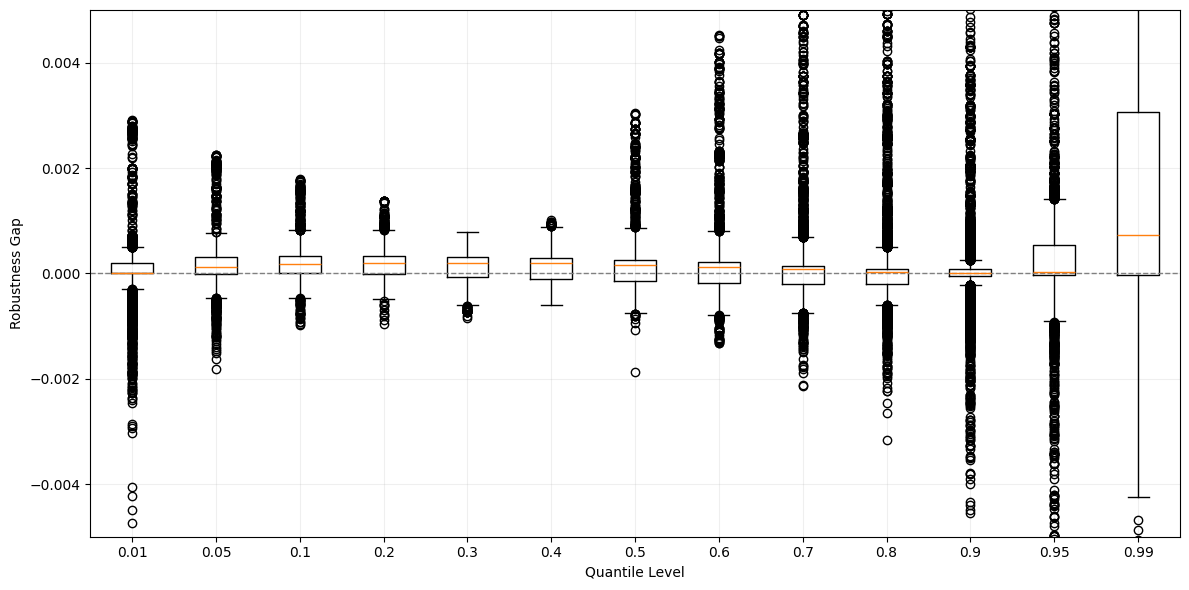

In [5]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'E']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.005, 0.005)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/518058016.py:15: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0, 0].boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/518058016.py:33: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  ax[0, 1].boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


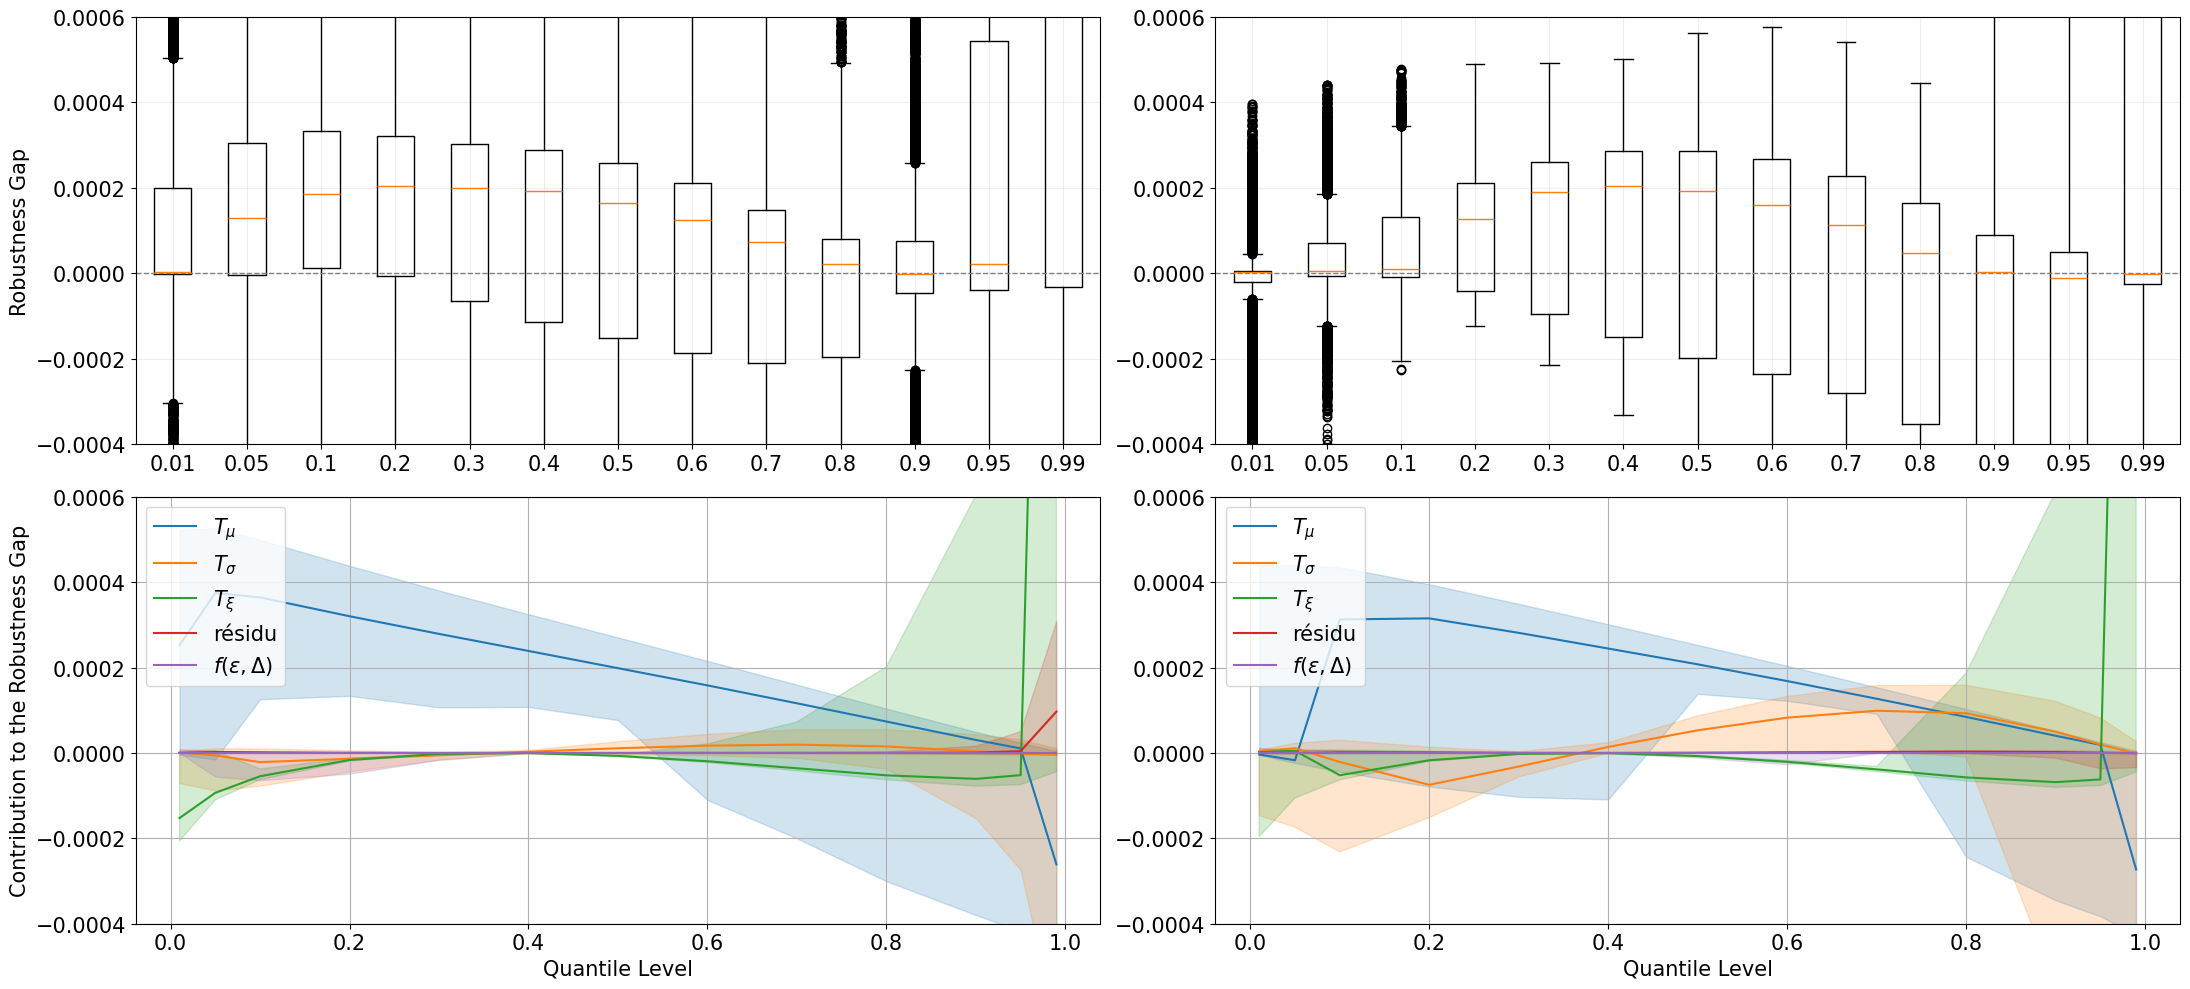

In [6]:
size = 15

fig, ax = plt.subplots(2, 2, figsize=(22, 10))
plt.subplots_adjust(hspace=0.4, wspace=0.3)

# ---------------------- Haut gauche ----------------------
boxplot_data = []
for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'E3'] 
    boxplot_data.append(erreurs)

ax[0, 0].boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
ax[0, 0].axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax[0, 0].tick_params(axis='both', labelsize=15)
#ax[0, 0].set_xlabel("Quantile Level", fontsize=size)
ax[0, 0].set_ylabel("Robustness Gap", fontsize=size)
ax[0, 0].set_ylim(-0.0004, 0.0006)
ax[0, 0].grid(True, alpha=0.2)
#ax[0, 0].set_title("Boxplot (modèle base)", fontsize=size)

# ---------------------- Haut droite ----------------------
boxplot_data = []
for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df_vglm[strq + 'E'] 
    boxplot_data.append(erreurs)

ax[0, 1].boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
ax[0, 1].axhline(y=0, color='gray', linestyle='--', linewidth=1)
ax[0, 1].tick_params(axis='both', labelsize=15)
#ax[0, 1].set_xlabel("Quantile Level", fontsize=size)
#ax[0, 1].set_ylabel("Robustness Gap", fontsize=size)
ax[0, 1].set_ylim(-0.0004, 0.0006)
ax[0, 1].grid(True, alpha=0.2)
#ax[0, 1].set_title("Boxplot (modèle complet)", fontsize=size)

# ---------------------- Bas gauche ----------------------
composantes = ['E_Tmu', 'E_Tsigma', 'E_Txi', 'E_R', 'T2']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
labels = [r'$T_\mu$', r'$T_\sigma$', r'$T_\xi$', 'résidu', r'$f(\epsilon, \Delta)$']

quantiles_str = [str(q)[2:] + ('0' if len(str(q)[2:]) == 1 else '') for q in liste_quantile]
quantiles_float = liste_quantile

for comp, color, label in zip(composantes, colors, labels):
    means, q1s, q3s = [], [], []
    for qstr in quantiles_str:
        values = df[qstr + comp].dropna()
        means.append(values.quantile(0.5))
        q1s.append(values.quantile(0.25))
        q3s.append(values.quantile(0.75))
    ax[1, 0].plot(quantiles_float, means, label=label, color=color)
    ax[1, 0].fill_between(quantiles_float, q1s, q3s, color=color, alpha=0.2)

ax[1, 0].set_xlabel("Quantile Level", fontsize=size)
ax[1, 0].set_ylabel("Contribution to the Robustness Gap", fontsize=size)
#ax[1, 0].set_title("Decomposition (modèle base)", fontsize=size)
ax[1, 0].legend(fontsize=size, loc="upper left")
ax[1, 0].tick_params(axis='both', labelsize=15)
ax[1, 0].set_ylim(-0.0004, 0.0006)
ax[1, 0].grid(True)

# ---------------------- Bas droite ----------------------
for comp, color, label in zip(composantes, colors, labels):
    means, q1s, q3s = [], [], []
    for qstr in quantiles_str:
        values = df_vglm[qstr + comp].dropna()
        means.append(values.quantile(0.5))
        q1s.append(values.quantile(0.25))
        q3s.append(values.quantile(0.75))
    ax[1, 1].plot(quantiles_float, means, label=label, color=color)
    ax[1, 1].fill_between(quantiles_float, q1s, q3s, color=color, alpha=0.2)

ax[1, 1].set_xlabel("Quantile Level", fontsize=size)
#ax[1, 1].set_ylabel("Contribution to the Robustness Gap", fontsize=size)
#ax[1, 1].set_title("Decomposition (modèle complet)", fontsize=size)
ax[1, 1].legend(fontsize=size, loc="upper left")
ax[1, 1].tick_params(axis='both', labelsize=15)
ax[1, 1].set_ylim(-0.0004, 0.0006)
ax[1, 1].grid(True)

plt.tight_layout()
plt.show()


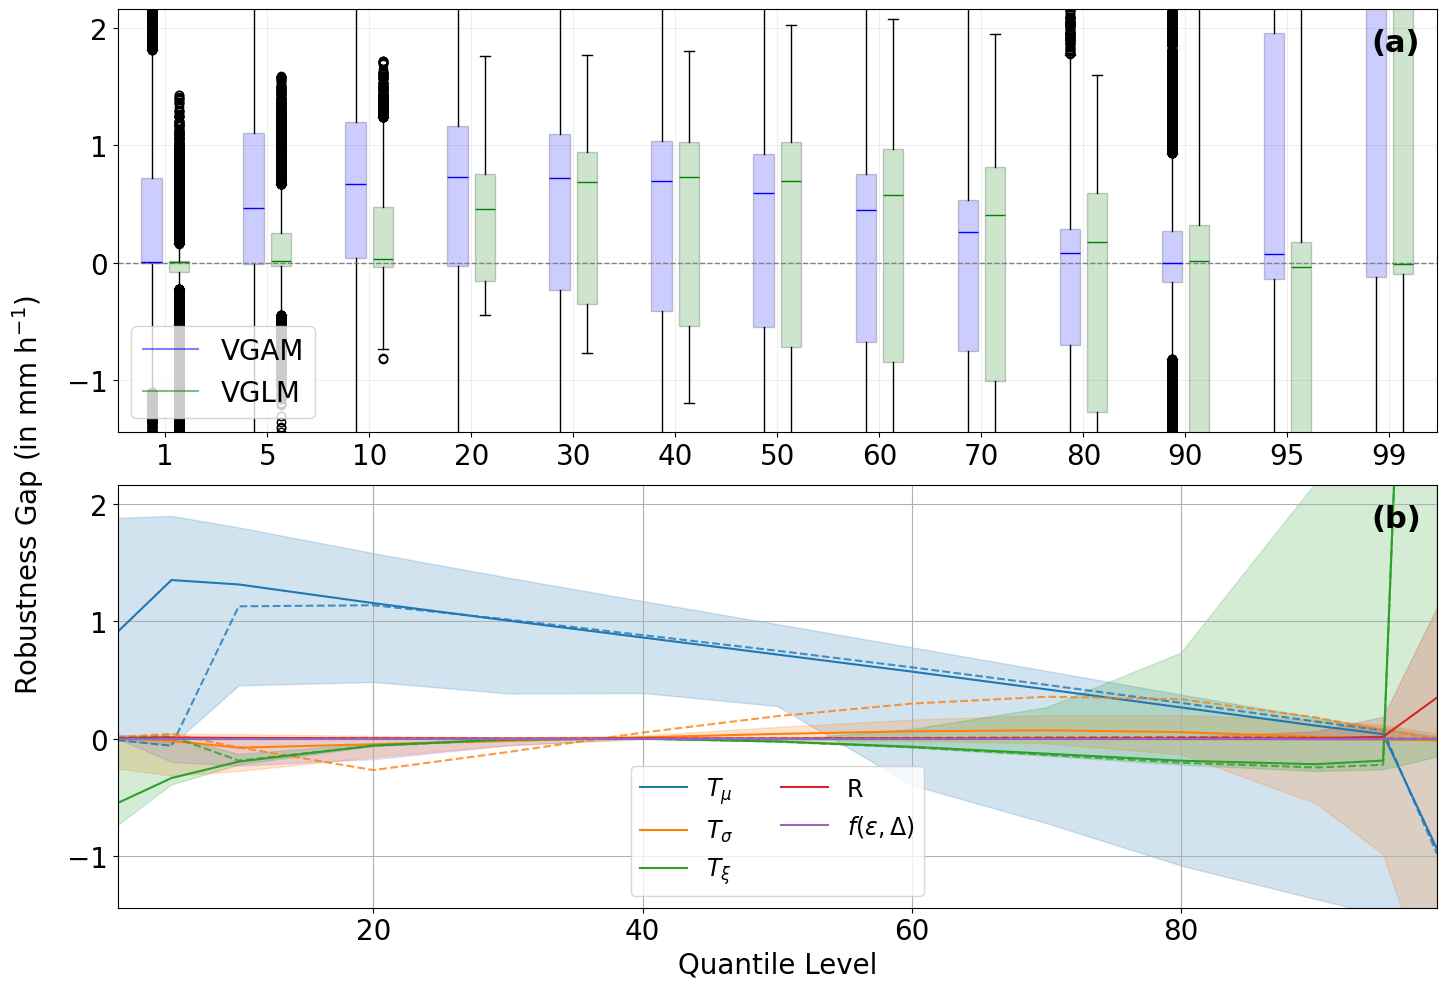

In [7]:
size = 20

fig, ax = plt.subplots(2, 1, figsize=(14, 10))
plt.subplots_adjust(hspace=0.3)

# ---------------------- Haut : Boxplot comparatif ----------------------
boxplot_data_base = []
boxplot_data_vglm = []

spacing = 1.5  # espace entre groupes
width = 0.3
n = len(liste_quantile)

positions_base = []
positions_vglm = []
center_positions = []

for i, q in enumerate(liste_quantile):
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    
    erreurs_base = (df[strq + 'E']*3600).dropna()
    erreurs_vglm = (df_vglm[strq + 'E']*3600).dropna()

    boxplot_data_base.append(erreurs_base)
    boxplot_data_vglm.append(erreurs_vglm)

    center = i * spacing + 1
    center_positions.append(center)
    positions_base.append(center - width/1.5)
    positions_vglm.append(center + width/1.5)

# Boxplots
bp_base = ax[0].boxplot(boxplot_data_base, positions=positions_base, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='blue', alpha=0.2),
                        medianprops=dict(color='blue'))

bp_vglm = ax[0].boxplot(boxplot_data_vglm, positions=positions_vglm, widths=width,
                        patch_artist=True, boxprops=dict(facecolor='green', alpha=0.2),
                        medianprops=dict(color='green'))

# Ligne horizontale de référence
ax[0].axhline(y=0, color='gray', linestyle='--', linewidth=1)

# X ticks au centre des paires
ax[0].set_xticks(center_positions)
ax[0].set_xticklabels([f"{q*100:.0f}" for q in liste_quantile], fontsize=size)

# Ajout légende manuelle
ax[0].plot([], [], color='blue', alpha=0.5, label='VGAM')
ax[0].plot([], [], color='green', alpha=0.5, label='VGLM')
ax[0].legend(fontsize=size, loc="lower left")

# Reste du style
ax[0].tick_params(axis='both', labelsize=size)
#ax[0].set_ylabel(r"Robustness Gap (in $mm.h^{-1}$)", fontsize=size)
#ax[0].set_xlabel("Quantile Level", fontsize=size)
ax[0].set_ylim(-0.0004*3600, 0.0006*3600)
ax[0].grid(True, alpha=0.2)


# ---------------------- Bas : Courbes avec décomposition ----------------------
composantes = ['E_Tmu', 'E_Tsigma', 'E_Txi', 'E_R', 'T2']
colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd']
labels = [r'$T_\mu$', r'$T_\sigma$', r'$T_\xi$', 'R', r'$f(\epsilon, \Delta)$']

quantiles_str = [str(q)[2:] + ('0' if len(str(q)[2:]) == 1 else '') for q in liste_quantile]
quantiles_float = liste_quantile *100

for comp, color, label in zip(composantes, colors, labels):
    # Modèle de base (ligne pleine)
    means_b, q1s_b, q3s_b = [], [], []
    for qstr in quantiles_str:
        values = df[qstr + comp].dropna()
        means_b.append(values.quantile(0.5)*3600)
        q1s_b.append(values.quantile(0.25)*3600)
        q3s_b.append(values.quantile(0.75)*3600)
    ax[1].plot(quantiles_float, means_b, label=label, color=color)
    ax[1].fill_between(quantiles_float, q1s_b, q3s_b, color=color, alpha=0.2)

    # Modèle complet (ligne pointillée)
    means_v, q1s_v, q3s_v = [], [], []
    for qstr in quantiles_str:
        values = df_vglm[qstr + comp].dropna()
        means_v.append(values.quantile(0.5)*3600)
    ax[1].plot(quantiles_float, means_v, linestyle='--', color=color, alpha=0.8)

ax[1].set_xlabel("Quantile Level", fontsize=size)
#ax[1].set_ylabel("Contribution to the Robustness Gap", fontsize=size)
ax[1].legend(fontsize=size-3, loc="lower center", ncol=2)
#ax[1].legend(fontsize=size-3, loc="lower left", ncol=3)
ax[1].tick_params(axis='both', labelsize=size)
ax[1].set_ylim(-0.0004*3600, 0.0006*3600)
ax[1].set_xlim(1, 99)
ax[1].grid(True)

fig.text(-0.03, 0.5, r"Robustness Gap (in mm h$^{-1}$)", va='center', rotation=90, fontsize=size)
ax[0].text(0.95, 0.9, "(a)", transform=ax[0].transAxes, fontsize=size+2, fontweight='bold')
ax[1].text(0.95, 0.9, "(b)", transform=ax[1].transAxes, fontsize=size+2, fontweight='bold')


plt.tight_layout()

#plt.savefig("Fig_9.pdf", format='pdf', dpi = 300)
#plt.savefig("Fig_9.png")
plt.show()


## 2.2. $T_1, T_2$

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1916218276.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


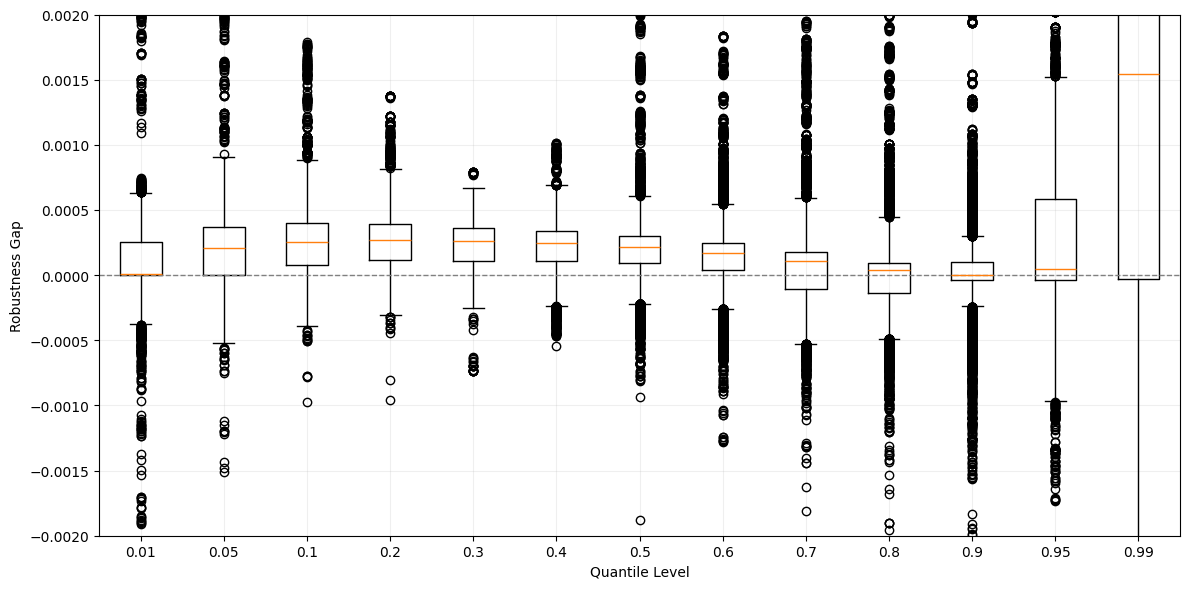

In [8]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'T1']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.002, 0.002)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1561365454.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


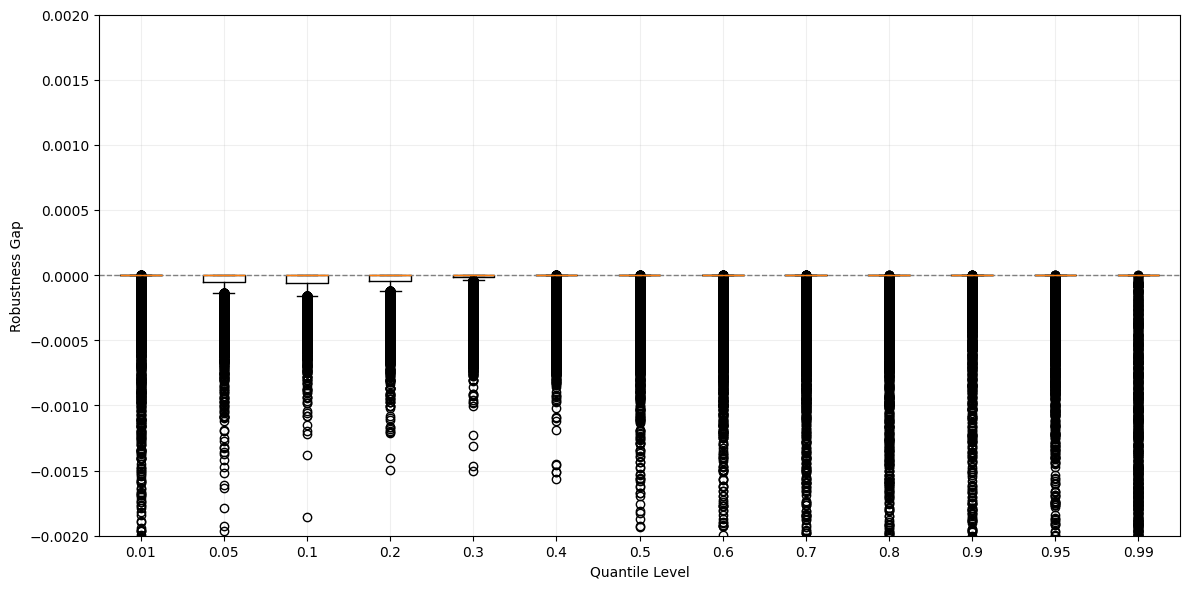

In [9]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'T2']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.002, 0.002)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


## 2.3. $\Delta$, $\epsilon$

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/2900348315.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


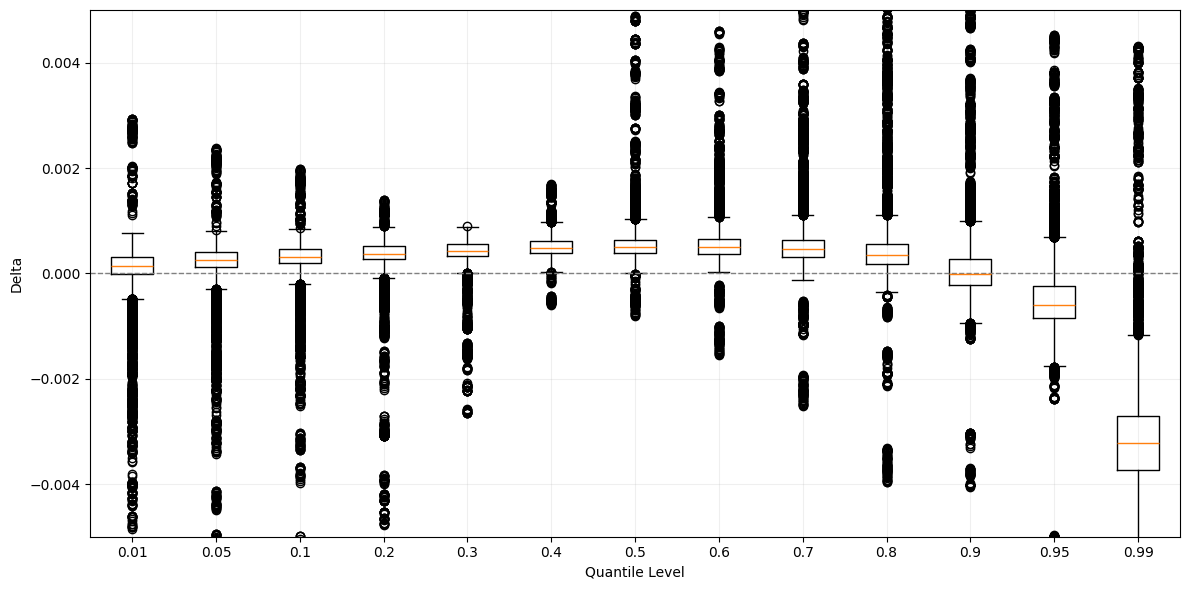

In [10]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'delta'] 
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Delta")
plt.ylim(-0.005, 0.005)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/2604159179.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


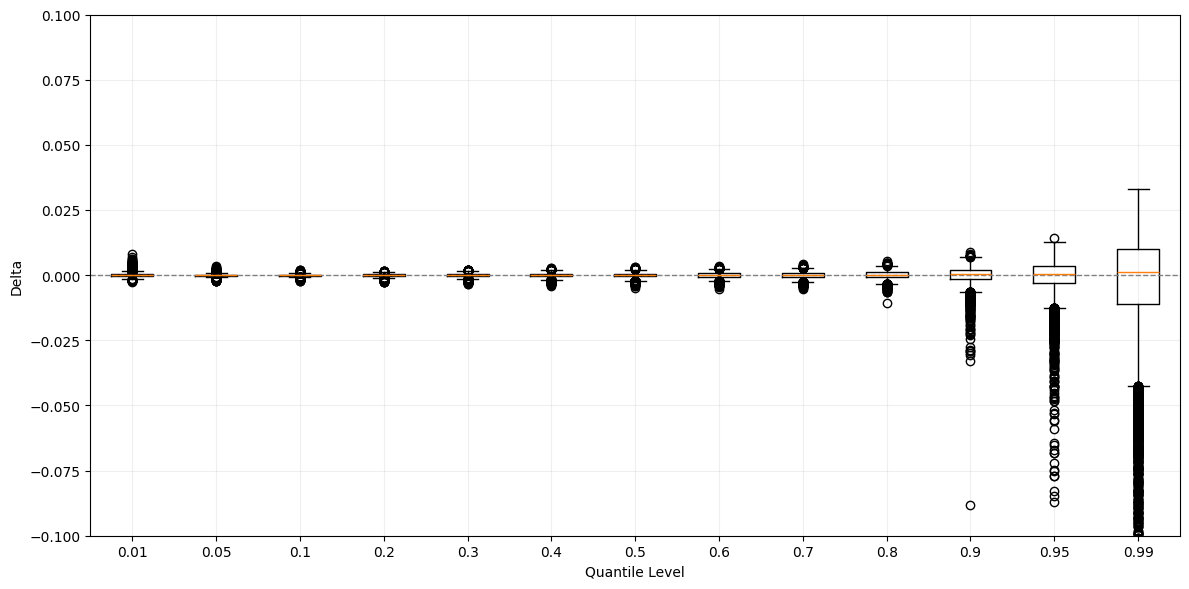

In [11]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'epsilon'] 
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Delta")
plt.ylim(-0.1, 0.1)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()

## 2.3. $T_\mu$, $T_\sigma$, $T_\xi$, R

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/2466897956.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


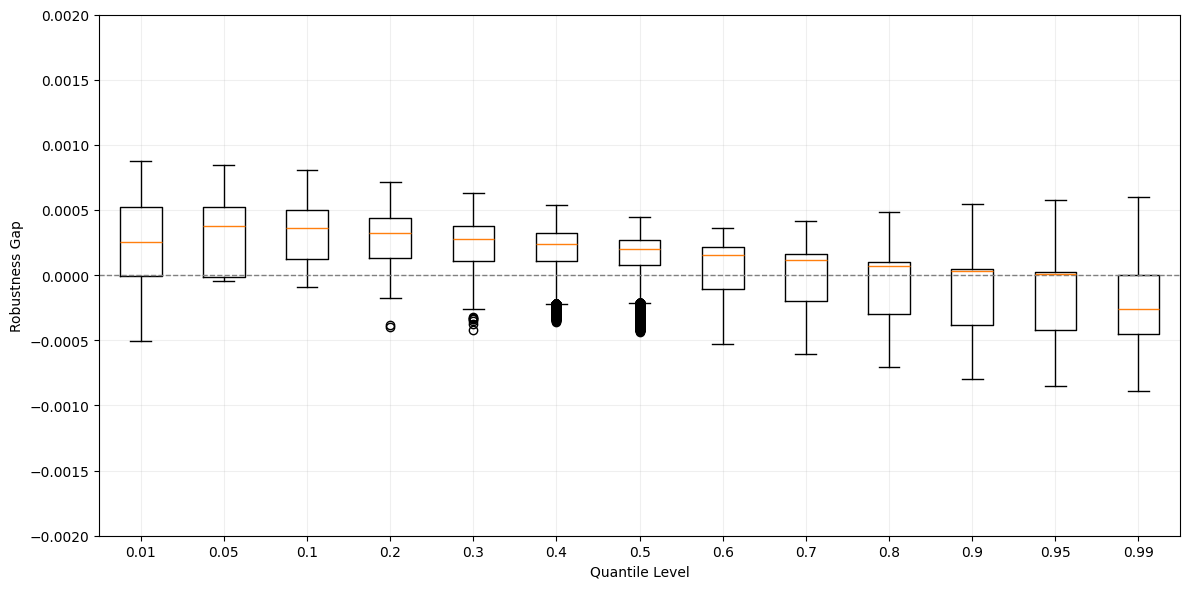

In [12]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'E_Tmu']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.002, 0.002)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1868242064.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


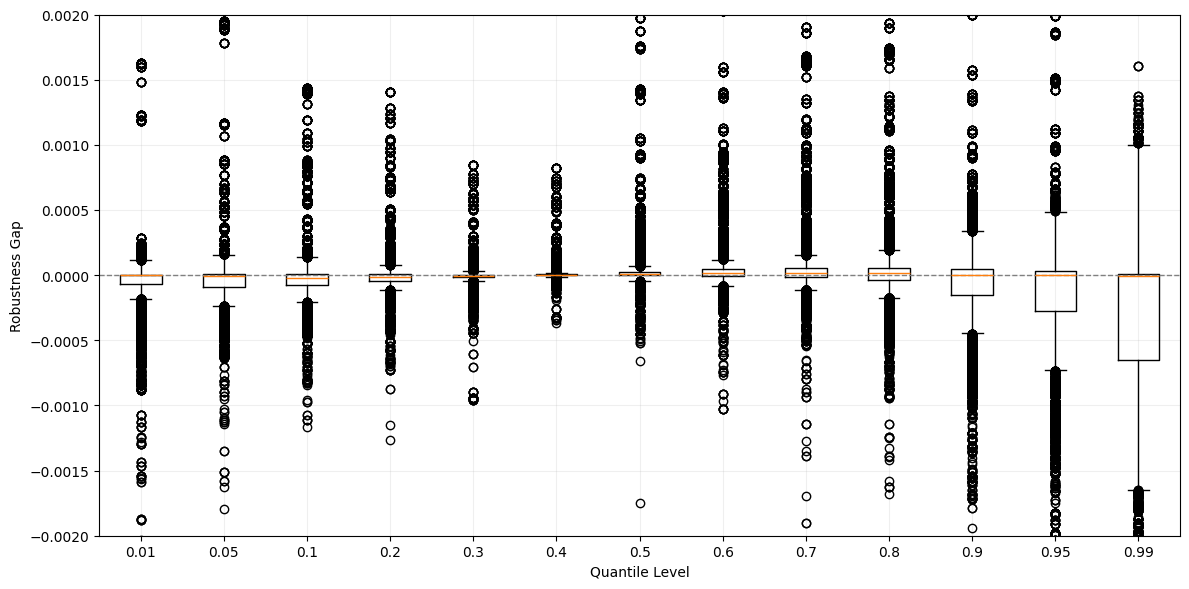

In [13]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'E_Tsigma']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.002, 0.002)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/2917103181.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


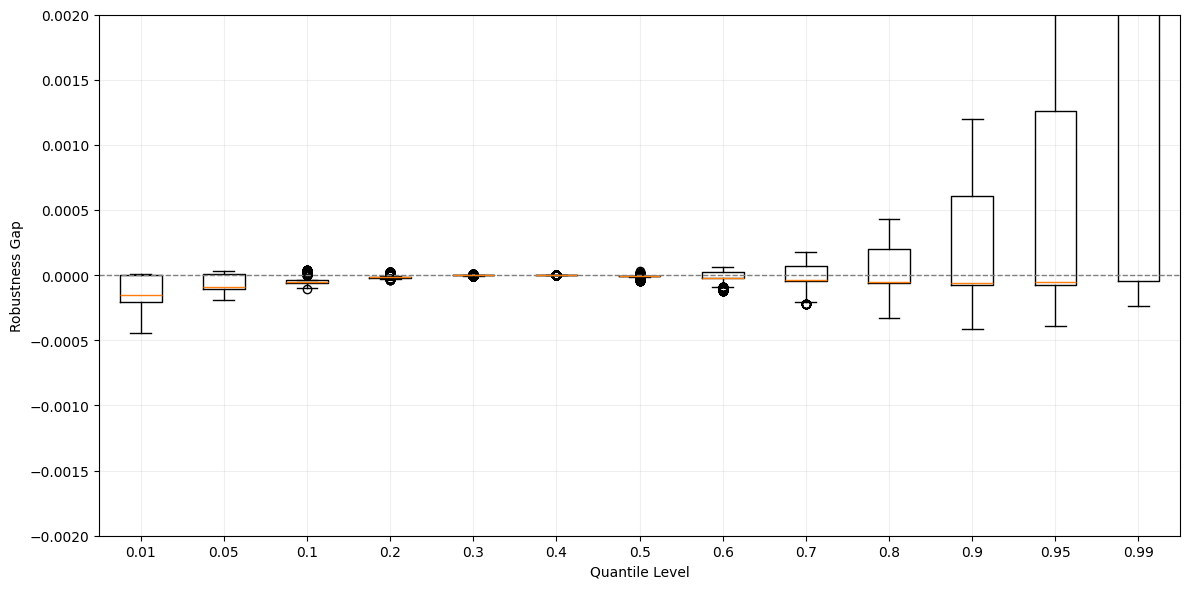

In [14]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'E_Txi']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.002, 0.002)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/4238092550.py:12: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])


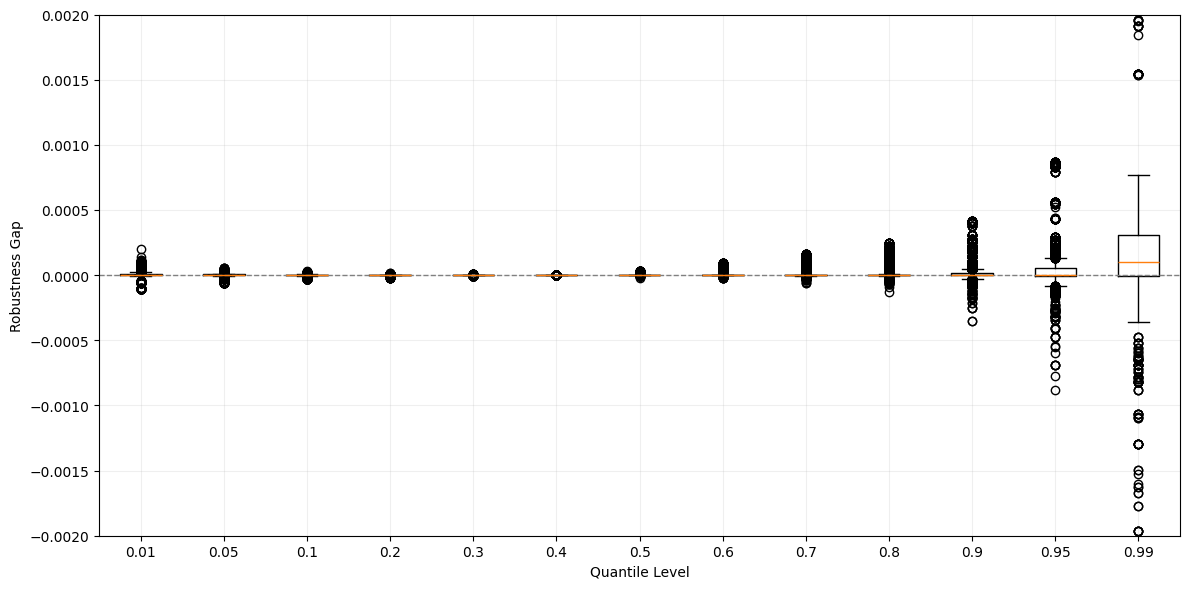

In [15]:
boxplot_data = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'
    erreurs = df[strq + 'E_R']
    boxplot_data.append(erreurs)

# boxplot
plt.figure(figsize=(12, 6))
plt.boxplot(boxplot_data, labels=[str(q) for q in liste_quantile])
plt.axhline(y=0, color='gray', linestyle='--', linewidth=1)
plt.xlabel("Quantile Level")
plt.ylabel("Robustness Gap")
plt.ylim(-0.002, 0.002)
plt.grid(True, alpha = 0.2)
plt.tight_layout()
plt.show()


## 2.4. Exploration Quantiles

In [16]:
liste_PP = []
liste_P = []
liste_F = []
liste_F1 = []
liste_F2 = []

for q in liste_quantile:
    strq = str(q)[2:]
    if len(strq) == 1 : strq += '0'
    liste_PP.append(np.mean(df[strq+'Q_PP']))
    liste_P.append(np.mean(df[strq+'QP']))
    liste_F1.append(np.mean(df[strq+'Q_F1']))
    liste_F2.append(np.mean(df[strq+'Q_F2']))
    liste_F.append(np.mean(df[strq+'QF']))

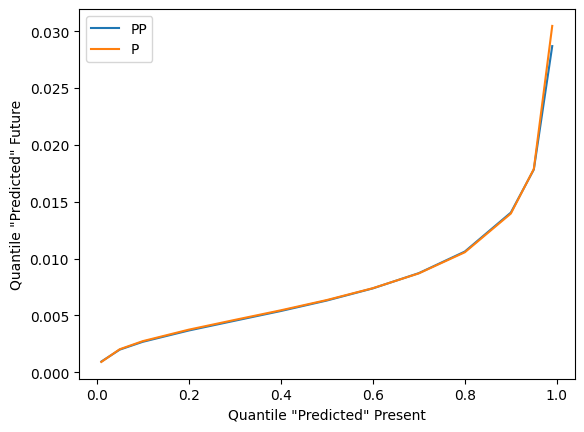

In [17]:
plt.plot(liste_quantile, liste_PP, label = 'PP')
plt.plot(liste_quantile, liste_P, label = 'P')
plt.xlabel('Quantile "Predicted" Present')
plt.ylabel('Quantile "Predicted" Future')
plt.legend()
plt.show()

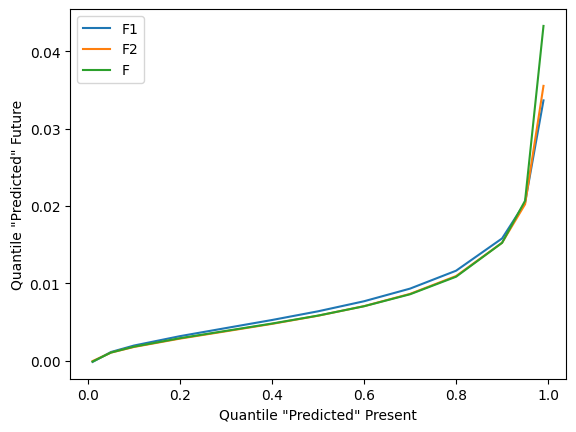

In [18]:
plt.plot(liste_quantile, liste_F1, label = 'F1')
plt.plot(liste_quantile, liste_F2, label = 'F2')
plt.plot(liste_quantile, liste_F, label = 'F')
plt.xlabel('Quantile "Predicted" Present')
plt.ylabel('Quantile "Predicted" Future')
plt.legend()
plt.show()

# 3. Exploration decomposition of $\Delta$

## 3.1. Example for a specific quantile 

90


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/246419732.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['T1'], df['T2'], df['T3'], df['R']], labels = ['$T_\\mu$', '$T_\\sigma$', '$T_\\xi$', '$Residu$'])


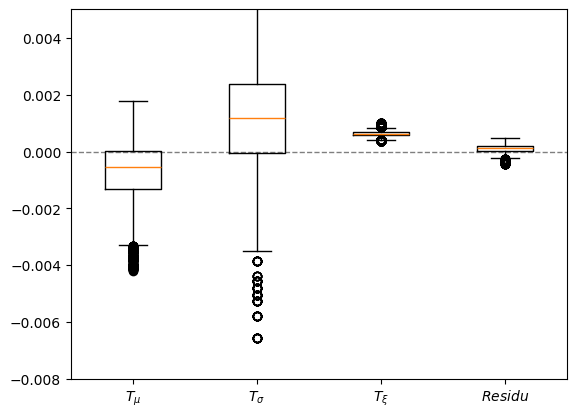

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/246419732.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.abs(df['T1']), np.abs(df['T2']), np.abs(df['T3']), np.abs(df['R'])], labels = ['$\\mu$', '$\\sigma$', '$\\xi$', '$Residu$'])


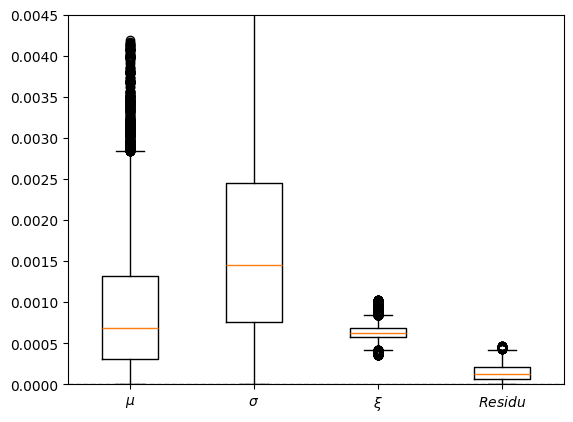

In [19]:
q = 0.9
strq = str(q)[2:]

if len(strq) == 1 : strq += '0'
print(strq)

df['T1'] = df['locF2'] - df['locPP']
df['T2'] = (df['scaleF2'] - df['scalePP']) * ((- np.log(q))**(-df['shapePP']) - 1) / df['shapePP']
#df['T3'] = (df['shapeF2'] - df['shapePP']) * ((-np.log(q))**(-df['shapePP']) * (-df['shapePP'] * np.log(-np.log(q)) - 1) + 1) / (df['shapePP']**2)
fq = -np.log(-np.log(q))
df['T3'] = (df['shapeF2'] - df['shapePP']) * (df['scalePP']/df['shapePP']) * ((-((-np.log(q))**(-df['shapePP']) - 1)/df['shapePP']) + (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapePP'])))

df['DQ'] =  df[strq+'Q_F2'] - df[strq+'Q_PP']
df['R'] = df['DQ'] - df['T1'] - df['T2'] - df['T3']


plt.boxplot([df['T1'], df['T2'], df['T3'], df['R']], labels = ['$T_\\mu$', '$T_\\sigma$', '$T_\\xi$', '$Residu$'])
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.ylim([-0.008, 0.005])
plt.show()

plt.boxplot([np.abs(df['T1']), np.abs(df['T2']), np.abs(df['T3']), np.abs(df['R'])], labels = ['$\\mu$', '$\\sigma$', '$\\xi$', '$Residu$'])
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.ylim([0, 0.0045])
plt.show()

40


/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/503591002.py:17: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df['T1'], df['T2'], df['T3'], df['R']], labels = ['$T_\\mu$', '$T_\\sigma$', '$T_\\xi$', '$Residu$'])


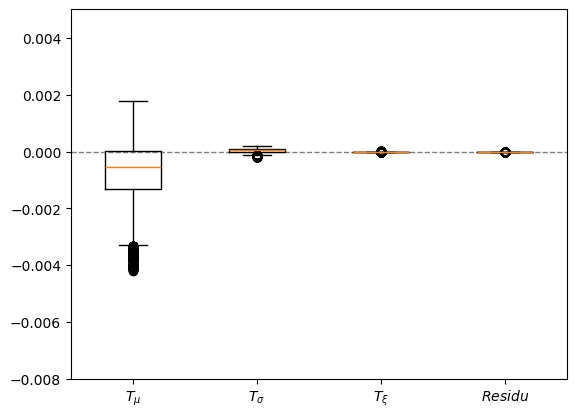

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/503591002.py:22: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([np.abs(df['T1']), np.abs(df['T2']), np.abs(df['T3']), np.abs(df['R'])], labels = ['$\\mu$', '$\\sigma$', '$\\xi$', '$Residu$'])


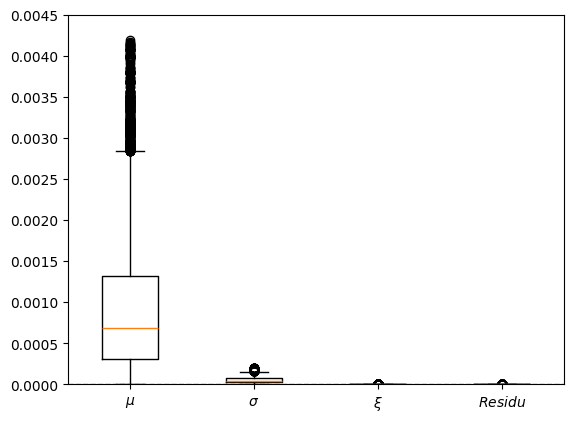

In [20]:
q = 0.4
strq = str(q)[2:]

if len(strq) == 1 : strq += '0'
print(strq)

df['T1'] = df['locF2'] - df['locPP']
df['T2'] = (df['scaleF2'] - df['scalePP']) * ((- np.log(q))**(-df['shapePP']) - 1) / df['shapePP']
#df['T3'] = (df['shapeF2'] - df['shapePP']) * ((-np.log(q))**(-df['shapePP']) * (-df['shapePP'] * np.log(-np.log(q)) - 1) + 1) / (df['shapePP']**2)
fq = -np.log(-np.log(q))
df['T3'] = (df['shapeF2'] - df['shapePP']) * (df['scalePP']/df['shapePP']) * ((-((-np.log(q))**(-df['shapePP']) - 1)/df['shapePP']) + (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapePP'])))

df['DQ'] =  df[strq+'Q_F2'] - df[strq+'Q_PP']
df['R'] = df['DQ'] - df['T1'] - df['T2'] - df['T3']


plt.boxplot([df['T1'], df['T2'], df['T3'], df['R']], labels = ['$T_\\mu$', '$T_\\sigma$', '$T_\\xi$', '$Residu$'])
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.ylim([-0.008, 0.005])
plt.show()

plt.boxplot([np.abs(df['T1']), np.abs(df['T2']), np.abs(df['T3']), np.abs(df['R'])], labels = ['$\\mu$', '$\\sigma$', '$\\xi$', '$Residu$'])
plt.axhline(0, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.ylim([0, 0.0045])
plt.show()

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/286742596.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, patch_artist=True, labels=labels)


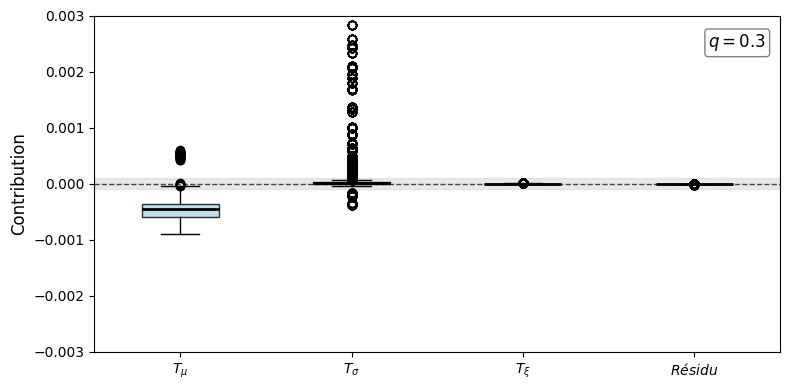

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/286742596.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, patch_artist=True, labels=labels)


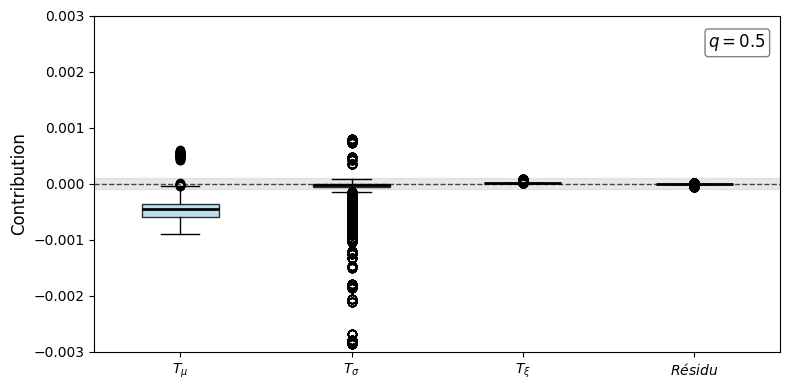

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/286742596.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, patch_artist=True, labels=labels)


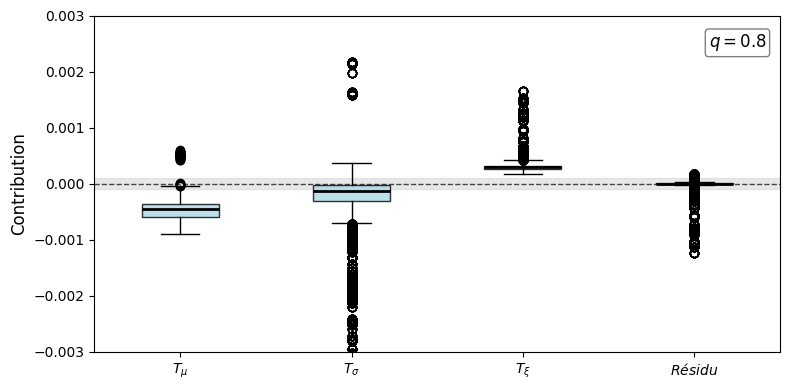

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/286742596.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  box = ax.boxplot(data, patch_artist=True, labels=labels)


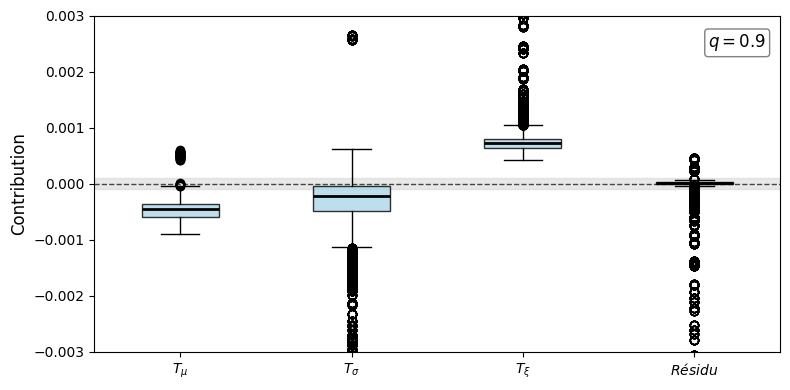

In [21]:
for q in [0.3, 0.5, 0.8, 0.9]:
    strq = str(q)[2:]
    if len(strq) == 1: strq += '0'

    # Calcul des composantes
    df['T1'] = df['locF2'] - df['locF1']
    df['T2'] = (df['scaleF2'] - df['scaleF1']) * ((- np.log(q))**(-df['shapeF1']) - 1) / df['shapeF1']
    fq = -np.log(-np.log(q))
    df['T3'] = (df['shapeF2'] - df['shapeF1']) * (df['scaleF1']/df['shapeF1']) * (
        (-((-np.log(q))**(-df['shapeF1']) - 1)/df['shapeF1']) +
        (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapeF1']))
    )
    df['DQ'] = df[strq+'Q_F2'] - df[strq+'Q_F1']
    df['R'] = df['DQ'] - df['T1'] - df['T2'] - df['T3']

    df_vglm['T1'] = df_vglm['locF2'] - df_vglm['locF1']
    df_vglm['T2'] = (df_vglm['scaleF2'] - df_vglm['scaleF1']) * ((- np.log(q))**(-df_vglm['shapeF1']) - 1) / df_vglm['shapeF1']
    fq = -np.log(-np.log(q))
    df_vglm['T3'] = (df_vglm['shapeF2'] - df_vglm['shapeF1']) * (df_vglm['scaleF1'] / df_vglm['shapeF1']) * (
        (-((-np.log(q))**(-df_vglm['shapeF1']) - 1) / df_vglm['shapeF1']) + 
        (-np.log(-np.log(q)) * (-np.log(q))**(-df_vglm['shapeF1']))
    )
    df_vglm['DQ'] = df_vglm[strq + 'Q_F2'] - df_vglm[strq + 'Q_F1']
    df_vglm['R'] = df_vglm['DQ'] - df_vglm['T1'] - df_vglm['T2'] - df_vglm['T3']

    data = [df['T1'], df_vglm['T1'],
            df['T2'], df_vglm['T2'],
            df['T3'], df_vglm['T3'],
            df['R'], df_vglm['R']]

    # Liste des données et labels
    data = [df['T1'], df['T2'], df['T3'], df['R']]
    labels = ['$T_\\mu$', '$T_\\sigma$', '$T_\\xi$', '$Résidu$']

    # Tracé
    fig, ax = plt.subplots(figsize=(8, 4))

    # Rectangle gris clair
    ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)

    # Boxplot
    box = ax.boxplot(data, patch_artist=True, labels=labels)

    # Style
    for patch, median in zip(box['boxes'], box['medians']):
        patch.set_facecolor('lightblue')
        patch.set_edgecolor('black')
        patch.set_alpha(0.8)
        median.set_color('black')
        median.set_linewidth(2)

    # Ligne horizontale
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Axes
    ax.set_ylabel('Contribution', fontsize=12)
    ax.set_ylim([-0.003, 0.003])
    ax.tick_params(axis='y', labelsize=10)

    # Annotation en haut à droite
    ax.text(0.98, 0.95, f"$q = {q:.1f}$", transform=ax.transAxes,
            ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.2'))

    plt.tight_layout()
    plt.show()


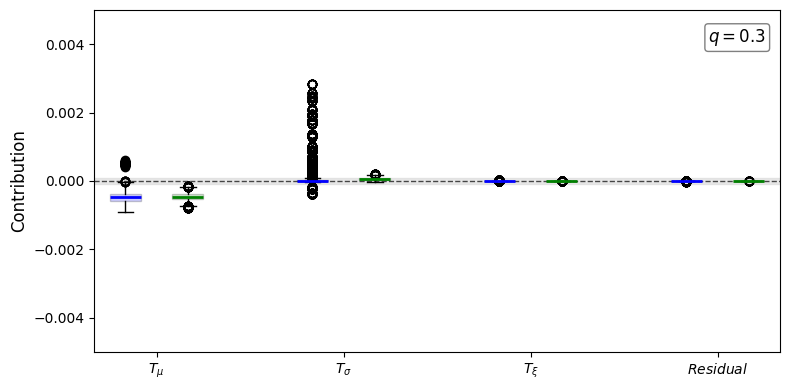

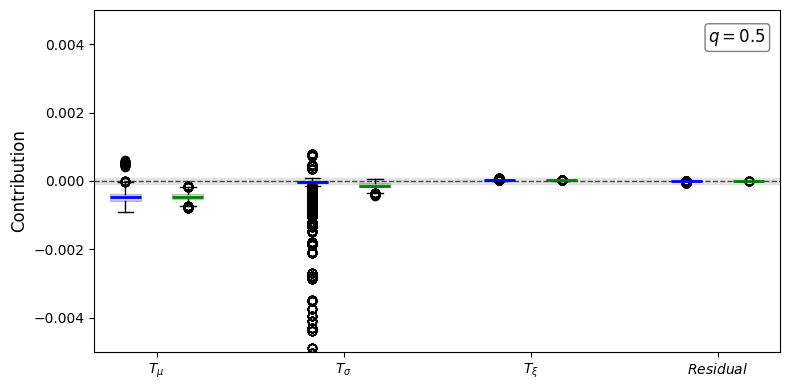

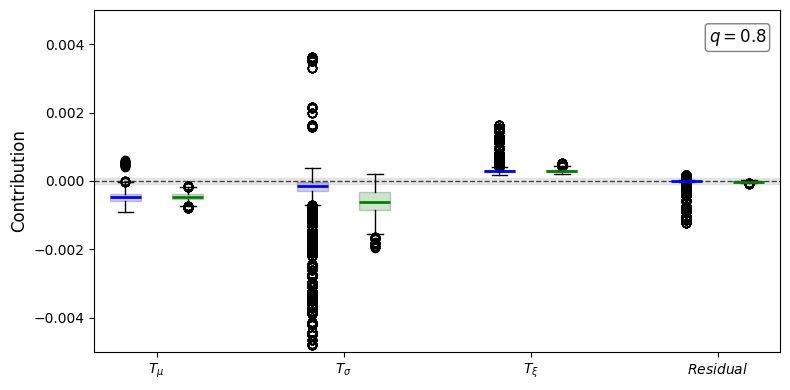

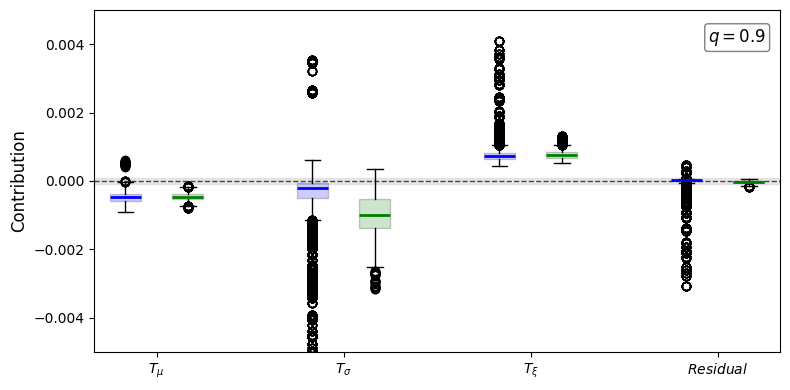

In [22]:
for q in [0.3, 0.5, 0.8, 0.9]:
    strq = str(q)[2:]
    if len(strq) == 1: strq += '0'

    # Calcul des composantes
    df['T1'] = df['locF2'] - df['locF1']
    df['T2'] = (df['scaleF2'] - df['scaleF1']) * ((- np.log(q))**(-df['shapeF1']) - 1) / df['shapeF1']
    fq = -np.log(-np.log(q))
    df['T3'] = (df['shapeF2'] - df['shapeF1']) * (df['scaleF1']/df['shapeF1']) * (
        (-((-np.log(q))**(-df['shapeF1']) - 1)/df['shapeF1']) +
        (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapeF1']))
    )
    df['DQ'] = df[strq+'Q_F2'] - df[strq+'Q_F1']
    df['R'] = df['DQ'] - df['T1'] - df['T2'] - df['T3']

    df_vglm['T1'] = df_vglm['locF2'] - df_vglm['locF1']
    df_vglm['T2'] = (df_vglm['scaleF2'] - df_vglm['scaleF1']) * ((- np.log(q))**(-df_vglm['shapeF1']) - 1) / df_vglm['shapeF1']
    fq = -np.log(-np.log(q))
    df_vglm['T3'] = (df_vglm['shapeF2'] - df_vglm['shapeF1']) * (df_vglm['scaleF1'] / df_vglm['shapeF1']) * (
        (-((-np.log(q))**(-df_vglm['shapeF1']) - 1) / df_vglm['shapeF1']) + (-np.log(-np.log(q)) * (-np.log(q))**(-df_vglm['shapeF1']))
    )
    df_vglm['DQ'] = df_vglm[strq + 'Q_F2'] - df_vglm[strq + 'Q_F1']
    df_vglm['R'] = df_vglm['DQ'] - df_vglm['T1'] - df_vglm['T2'] - df_vglm['T3']

    data = [df['T1'], df_vglm['T1'],
            df['T2'], df_vglm['T2'],
            df['T3'], df_vglm['T3'],
            df['R'], df_vglm['R']]
    
    positions = [1, 2, 4, 5, 7, 8, 10, 11]

    # Tracé
    fig, ax = plt.subplots(figsize=(8, 4))
    box = ax.boxplot(data, patch_artist=True, positions=positions)

    # Rectangle gris clair
    ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)

    for median, patch, color in zip(box['medians'], box['boxes'], ['blue', 'green'] * 4):
        patch.set_facecolor(color)
        patch.set_edgecolor('black')
        patch.set_alpha(0.2)
        median.set_color(color)
        median.set_linewidth(2)


    # ➤ Supprimer les ticks par défaut
    ax.set_xticks([])  # on vide tout

    # ➤ Ajouter des ticks personnalisés centrés entre chaque paire (VGAM/VGLM)
    ax.set_xticks([1.5, 4.5, 7.5, 10.5])
    ax.set_xticklabels(['$T_\\mu$', '$T_\\sigma$', '$T_\\xi$', '$Residual$'])


    # Ligne horizontale
    ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

    # Axes
    ax.set_ylabel('Contribution', fontsize=12)
    ax.set_ylim([-0.005, 0.005])
    ax.tick_params(axis='y', labelsize=10)

    # Annotation en haut à droite
    ax.text(0.98, 0.95, f"$q = {q:.1f}$", transform=ax.transAxes,
            ha='right', va='top', fontsize=12, bbox=dict(facecolor='white', edgecolor='grey', boxstyle='round,pad=0.2'))

    plt.tight_layout()
    plt.show()


## 3.2. General

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1423518993.py:27: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(liste11, labels = liste_quantile)


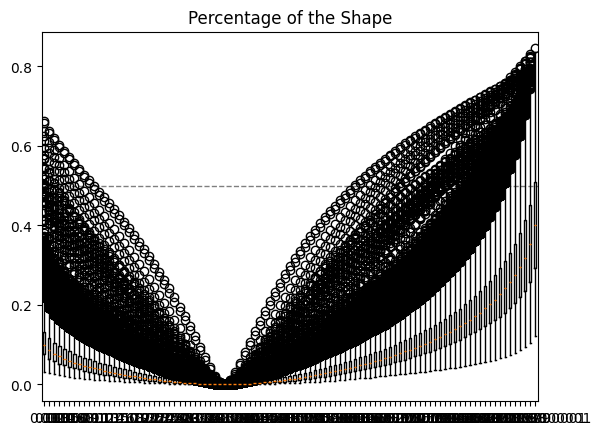

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1423518993.py:32: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(liste22, labels = liste_quantile)


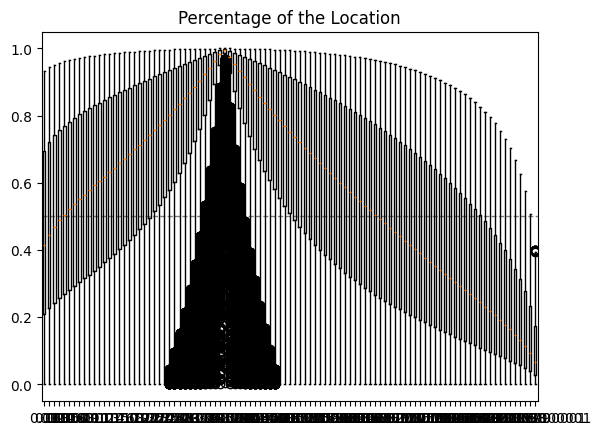

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1423518993.py:37: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(liste33, labels = liste_quantile)


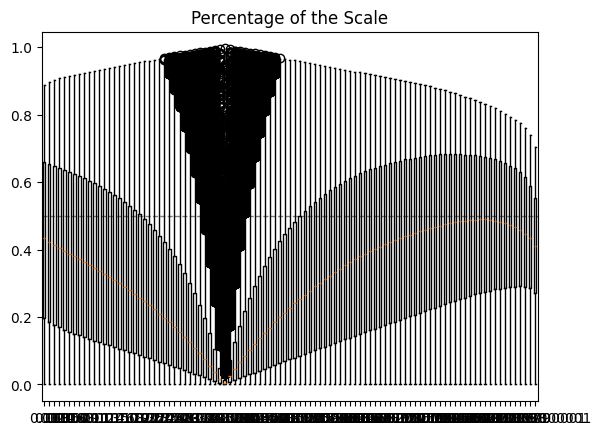

/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/1423518993.py:42: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(liste44, labels = liste_quantile)


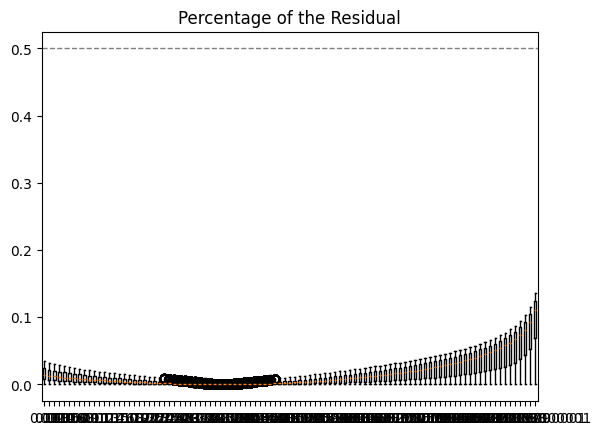

In [23]:
liste1, liste2, liste3, liste4 = [], [], [], []
liste11, liste22, liste33, liste44 = [], [], [], []
liste111, liste222, liste333, liste444 = [], [], [], []

liste_quantile = np.arange(0.01, 1, 0.01)

for q in liste_quantile:
    df['T1'] = df['locF2'] - df['locPP']
    df['T2'] = (df['scaleF2'] - df['scalePP']) * ((- np.log(q))**(-df['shapePP']) - 1) / df['shapePP']
    #df['T3'] = (df['shapeF2'] - df['shapePP']) * ((-np.log(q))**(-df['shapePP']) * (-df['shapePP'] * np.log(-np.log(q)) - 1) + 1) / (df['shapePP']**2)
    df['T3'] = (df['shapeF2'] - df['shapePP']) * (df['scalePP']/df['shapePP']) * ((-((-np.log(q))**(-df['shapePP']) - 1)/df['shapePP']) + (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapePP'])))
    df['qQ_PP'] = df['locPP'] + (df['scalePP']/df['shapePP']) * ((-np.log(q))**(-df['shapePP']) - 1)
    df['qQ_F2'] = df['locF2'] + (df['scaleF2']/df['shapeF2']) * ((-np.log(q))**(-df['shapeF2']) - 1)
    df['DQ'] =  df['qQ_F2'] - df['qQ_PP']
    df['R'] = df['DQ'] - df['T1'] - df['T2'] - df['T3']

    liste11.append(np.abs(df['T3']) / (np.abs(df['T1']) + np.abs(df['T2']) + np.abs(df['T3']) + np.abs(df['R'])))
    liste22.append(np.abs(df['T1']) / (np.abs(df['T1']) + np.abs(df['T2']) + np.abs(df['T3']) + np.abs(df['R'])))
    liste33.append(np.abs(df['T2']) / (np.abs(df['T1']) + np.abs(df['T2']) + np.abs(df['T3']) + np.abs(df['R'])))
    liste44.append(np.abs(df['R']) / (np.abs(df['T1']) + np.abs(df['T2']) + np.abs(df['T3']) + np.abs(df['R'])))
    
    liste111.append(np.mean(df['T3']))
    liste222.append(np.mean(df['T1']))
    liste333.append(np.mean(df['T2']))
    liste444.append(np.mean(df['R']))

plt.boxplot(liste11, labels = liste_quantile)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.title('Percentage of the Shape')
plt.show()

plt.boxplot(liste22, labels = liste_quantile)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.title('Percentage of the Location')
plt.show()

plt.boxplot(liste33, labels = liste_quantile)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.title('Percentage of the Scale')
plt.show()

plt.boxplot(liste44, labels = liste_quantile)
plt.axhline(0.5, color='black', linestyle='--', linewidth=1, alpha = 0.5) 
plt.title('Percentage of the Residual')
plt.show()


<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
<>:7: SyntaxWarning: invalid escape sequence '\e'
<>:8: SyntaxWarning: invalid escape sequence '\m'
<>:9: SyntaxWarning: invalid escape sequence '\s'
/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/3619191849.py:7: SyntaxWarning: invalid escape sequence '\e'
  plt.plot(liste_quantile, liste111, label = '$T_\epsilon$')
/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/3619191849.py:8: SyntaxWarning: invalid escape sequence '\m'
  plt.plot(liste_quantile, liste222, label = '$T_\mu$')
/var/folders/l9/fpnjgbdj5c3f9l3hvpkt77gr0000gn/T/ipykernel_5541/3619191849.py:9: SyntaxWarning: invalid escape sequence '\s'
  plt.plot(liste_quantile, liste333, label = '$T_\sigma$')


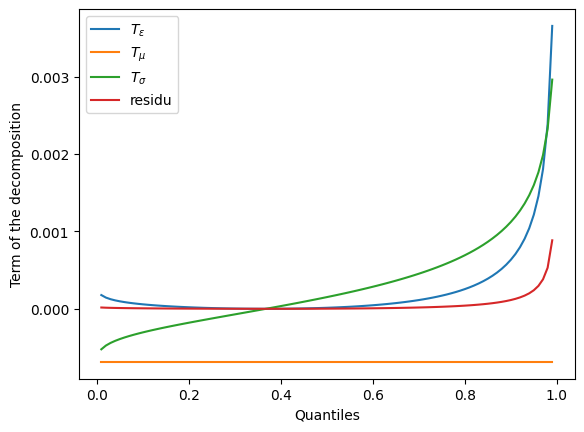

In [24]:
liste1 = np.array(liste1)*100
liste2 = np.array(liste2)*100
liste3 = np.array(liste3)*100
liste4 = np.array(liste4)*100


plt.plot(liste_quantile, liste111, label = '$T_\epsilon$')
plt.plot(liste_quantile, liste222, label = '$T_\mu$')
plt.plot(liste_quantile, liste333, label = '$T_\sigma$')
plt.plot(liste_quantile, liste444, label = 'residu')
plt.legend()
plt.xlabel('Quantiles')
plt.ylabel('Term of the decomposition')
plt.show()

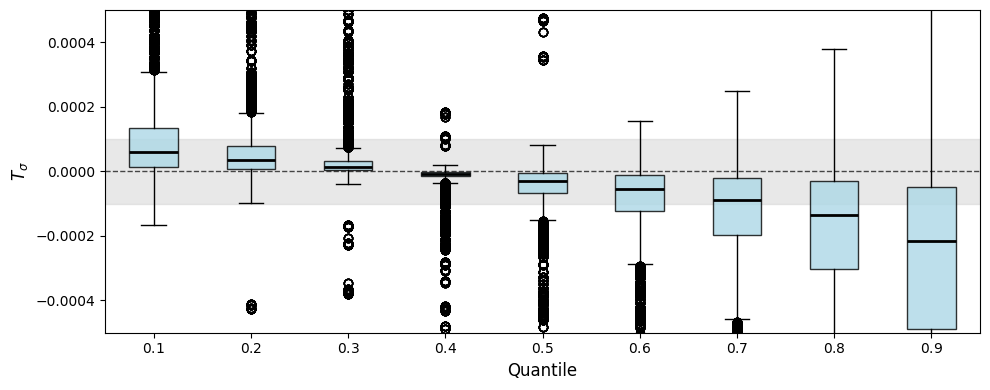

In [25]:
q_list = np.round(np.arange(0.1, 1.0, 0.1), 1)  # [0.1, 0.2, ..., 0.9]
T2_list = []

for q in q_list:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'

    T2 = (df['scaleF2'] - df['scaleF1']) * ((- np.log(q))**(-df['shapeF1']) - 1) / df['shapeF1']
    T2_list.append(T2)


fig, ax = plt.subplots(figsize=(10, 4))
positions = np.arange(1, len(q_list)+1)


ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)


box = ax.boxplot(T2_list, patch_artist=True, positions=positions)

for patch, median in zip(box['boxes'], box['medians']):
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
    patch.set_alpha(0.8)
    median.set_color('black')
    median.set_linewidth(2)


ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xticks(positions)
ax.set_xticklabels([f'${q:.1f}$' for q in q_list], fontsize=10)
ax.set_ylabel('$T_\\sigma$', fontsize=12)
ax.set_xlabel('Quantile', fontsize=12)
ax.set_ylim([-0.0005, 0.0005])
ax.tick_params(axis='y', labelsize=10)
#ax.set_title('Décomposition de $T_\\sigma$ pour différents quantiles', fontsize=13)

plt.tight_layout()
plt.show()


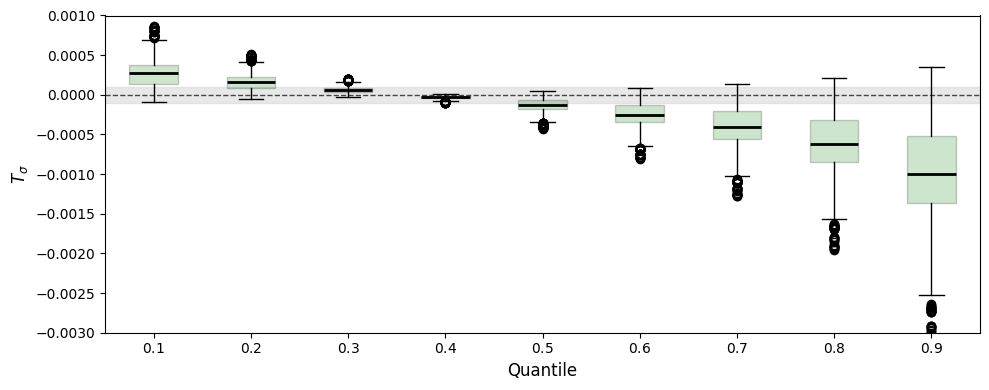

In [26]:
q_list = np.round(np.arange(0.1, 1.0, 0.1), 1)  # [0.1, 0.2, ..., 0.9]
T2_list = []

for q in q_list:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'

    T2 = (df_vglm['scaleF2'] - df_vglm['scaleF1']) * ((- np.log(q))**(-df_vglm['shapeF1']) - 1) / df_vglm['shapeF1']
    T2_list.append(T2)

fig, ax = plt.subplots(figsize=(10, 4))
positions = np.arange(1, len(q_list)+1)

ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)

box = ax.boxplot(T2_list, patch_artist=True, positions=positions)

for patch, median in zip(box['boxes'], box['medians']):
    patch.set_facecolor('green')
    patch.set_edgecolor('black')
    patch.set_alpha(0.2)
    median.set_color('black')
    median.set_linewidth(2)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xticks(positions)
ax.set_xticklabels([f'${q:.1f}$' for q in q_list], fontsize=10)
ax.set_ylabel('$T_\\sigma$', fontsize=12)
ax.set_xlabel('Quantile', fontsize=12)
ax.set_ylim([-0.003, 0.001])
ax.tick_params(axis='y', labelsize=10)
#ax.set_title('Décomposition de $T_\\sigma$ pour différents quantiles', fontsize=13)

plt.tight_layout()
plt.show()


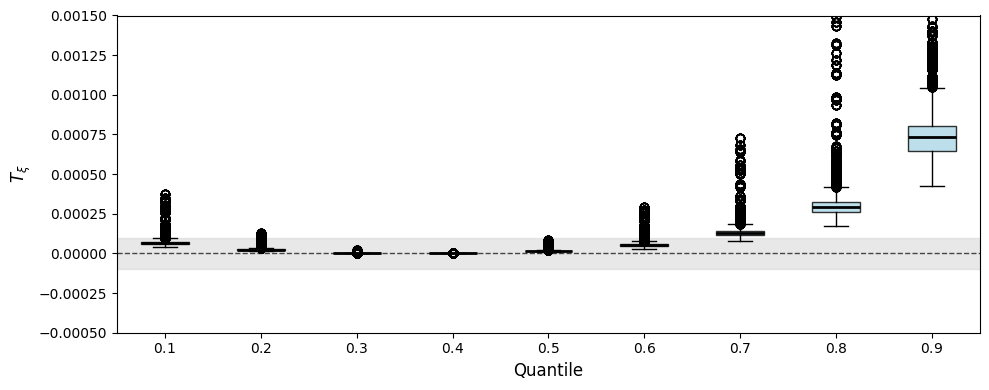

In [27]:
q_list = np.round(np.arange(0.1, 1.0, 0.1), 1)  # [0.1, 0.2, ..., 0.9]
T3_list = []

for q in q_list:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'

    fq = -np.log(-np.log(q))
    T3 = (df['shapeF2'] - df['shapeF1']) * (df['scaleF1']/df['shapeF1']) * ((-((-np.log(q))**(-df['shapeF1']) - 1)/df['shapeF1']) + (-np.log(-np.log(q)) * (-np.log(q))**(-df['shapeF1'])))
    T3_list.append(T3)

fig, ax = plt.subplots(figsize=(10, 4))
positions = np.arange(1, len(q_list)+1)


ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)


box = ax.boxplot(T3_list, patch_artist=True, positions=positions)

for patch, median in zip(box['boxes'], box['medians']):
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
    patch.set_alpha(0.8)
    median.set_color('black')
    median.set_linewidth(2)


ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)


ax.set_xticks(positions)
ax.set_xticklabels([f'${q:.1f}$' for q in q_list], fontsize=10)
ax.set_ylabel('$T_\\xi$', fontsize=12)
ax.set_xlabel('Quantile', fontsize=12)
ax.set_ylim([-0.0005, 0.0015])
ax.tick_params(axis='y', labelsize=10)
#ax.set_title('Décomposition de $T_\\sigma$ pour différents quantiles', fontsize=13)

plt.tight_layout()
plt.show()


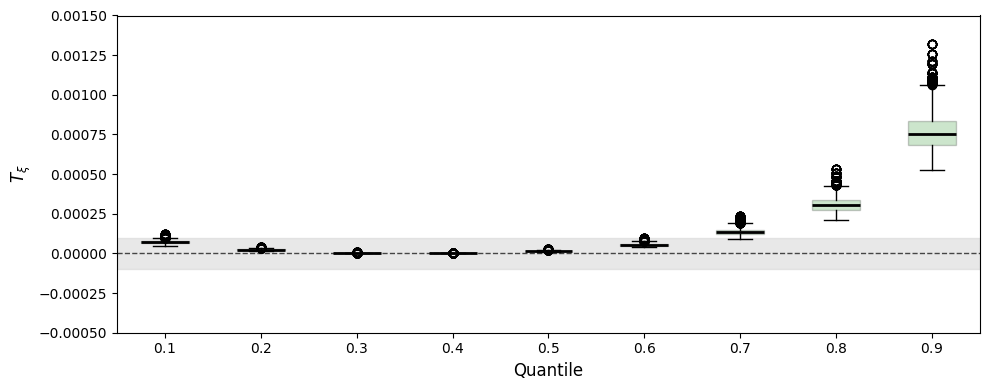

In [28]:
q_list = np.round(np.arange(0.1, 1.0, 0.1), 1)  # [0.1, 0.2, ..., 0.9]
T3_list = []


for q in q_list:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'

    fq = -np.log(-np.log(q))
    T3 = (df_vglm['shapeF2'] - df_vglm['shapeF1']) * (df_vglm['scaleF1']/df_vglm['shapeF1']) * ((-((-np.log(q))**(-df_vglm['shapeF1']) - 1)/df_vglm['shapeF1']) + (-np.log(-np.log(q)) * (-np.log(q))**(-df_vglm['shapeF1'])))
    T3_list.append(T3)


fig, ax = plt.subplots(figsize=(10, 4))
positions = np.arange(1, len(q_list)+1)


ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)

box = ax.boxplot(T3_list, patch_artist=True, positions=positions)

for patch, median in zip(box['boxes'], box['medians']):
    patch.set_facecolor('green')
    patch.set_edgecolor('black')
    patch.set_alpha(0.2)
    median.set_color('black')
    median.set_linewidth(2)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xticks(positions)
ax.set_xticklabels([f'${q:.1f}$' for q in q_list], fontsize=10)
ax.set_ylabel('$T_\\xi$', fontsize=12)
ax.set_xlabel('Quantile', fontsize=12)
ax.set_ylim([-0.0005, 0.0015])
ax.tick_params(axis='y', labelsize=10)
#ax.set_title('Décomposition de $T_\\sigma$ pour différents quantiles', fontsize=13)

plt.tight_layout()
plt.show()


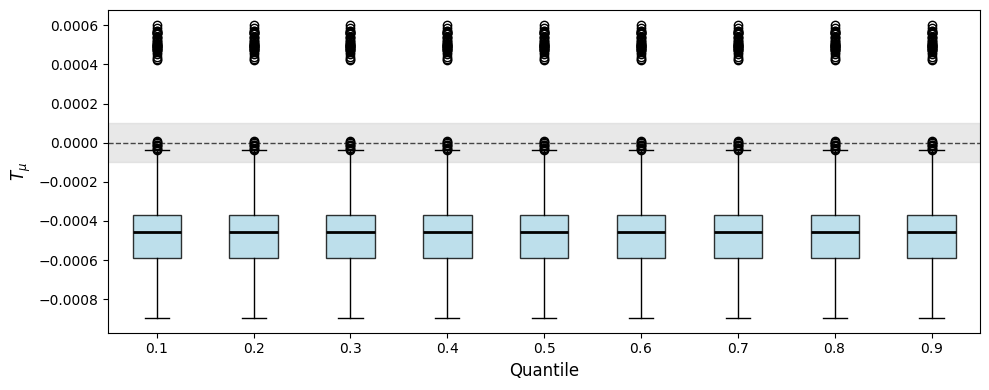

In [29]:
q_list = np.round(np.arange(0.1, 1.0, 0.1), 1)  # [0.1, 0.2, ..., 0.9]
T1_list = []

for q in q_list:
    strq = str(q)[2:]
    if len(strq) == 1:
        strq += '0'

    fq = -np.log(-np.log(q))
    T1 = df['locF2'] - df['locF1']
    T1_list.append(T1)

fig, ax = plt.subplots(figsize=(10, 4))
positions = np.arange(1, len(q_list)+1)

ax.axhspan(-0.0001, 0.0001, color='lightgrey', alpha=0.5)

box = ax.boxplot(T1_list, patch_artist=True, positions=positions)

for patch, median in zip(box['boxes'], box['medians']):
    patch.set_facecolor('lightblue')
    patch.set_edgecolor('black')
    patch.set_alpha(0.8)
    median.set_color('black')
    median.set_linewidth(2)

ax.axhline(0, color='black', linestyle='--', linewidth=1, alpha=0.7)

ax.set_xticks(positions)
ax.set_xticklabels([f'${q:.1f}$' for q in q_list], fontsize=10)
ax.set_ylabel('$T_\\mu$', fontsize=12)
ax.set_xlabel('Quantile', fontsize=12)
#ax.set_ylim([-0.0005, 0.0005])
ax.tick_params(axis='y', labelsize=10)
#ax.set_title('Décomposition de $T_\\sigma$ pour différents quantiles', fontsize=13)

plt.tight_layout()
plt.show()
